In [69]:
import os
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
dataset_path = '/kaggle/input/plantdisease/PlantVillage'
selected_classes = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 
                    'Tomato_healthy', 'Tomato_Late_blight']  

data = []
labels = []
# Iterate through the dataset directory
for class_name in os.listdir(dataset_path):
    if class_name in selected_classes:
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append(img_path)
            labels.append(class_name)

df = pd.DataFrame({'data': data, 'label': labels})

In [36]:
df

,data,label
0,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
1,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
2,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
3,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
4,/kaggle/input/plantdisease/PlantVillage/Pepper...,Pepper__bell___Bacterial_spot
...,...,...
6970,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
6971,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
6972,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight
6973,/kaggle/input/plantdisease/PlantVillage/Tomato...,Tomato_Late_blight


In [21]:
image = Image.open("/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG")
width, height = image.size
print(f"Width: {width}, Height: {height}")

Width: 256, Height: 256


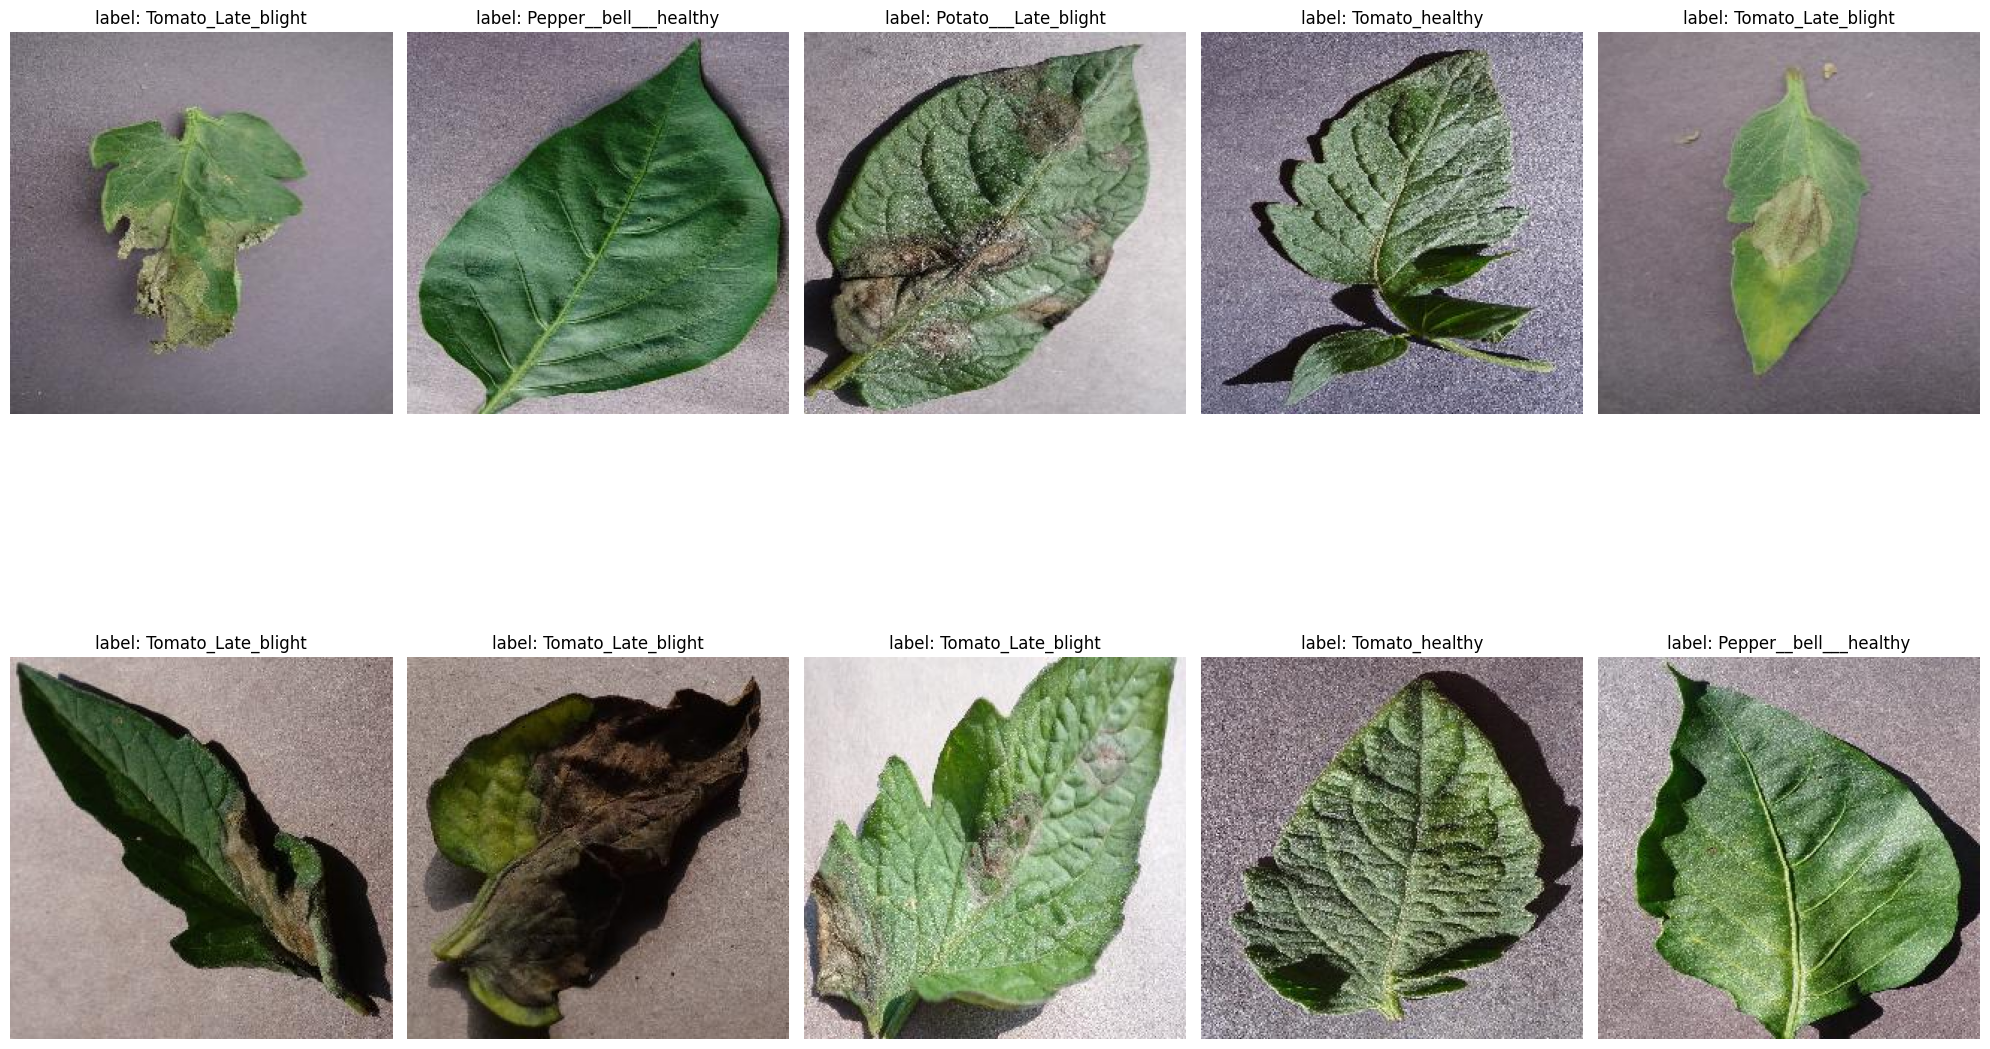

In [4]:
plt.figure(figsize=(20, 15))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = np.random.choice(df.index)
    filename = df.loc[index, 'data']
    category = df.loc[index, 'label']
    img = Image.open(filename)
    plt.imshow(img)
    plt.title(f'label: {category}')
    plt.axis('off') 

plt.tight_layout()
plt.show()

In [41]:
def extract_hog_features(image):
    # Convert the image to grayscale using cv2
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    hog = cv2.HOGDescriptor()
    
    # Compute HOG features
    hog_features = hog.compute(gray_image)

    return hog_features.flatten()

In [42]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)
batch_size = 100
batches = [df_shuffled[i:i+batch_size] for i in range(0, len(df_shuffled), batch_size)]

# Process images in batches
for batch in batches:
    features_list=[]
    labels_list=[]
    for index, row in batch.iterrows():
        image = cv2.imread(row['data'])
        hog_features= extract_hog_features(image)
        features_list.append(hog_features)
        labels_list.append(row['label'])

In [43]:
# Convert lists to NumPy arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)
# Use LabelEncoder to convert class names into numeric labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels_array)

In [45]:
numeric_labels

array([1, 0, 1, 4, 3, 4, 2, 0, 0, 2, 4, 1, 4, 4, 1, 0, 1, 1, 3, 3, 1, 1,
       0, 1, 4, 4, 3, 4, 3, 3, 1, 3, 4, 3, 1, 3, 0, 3, 4, 1, 0, 4, 0, 4,
       0, 3, 1, 0, 2, 0, 3, 4, 3, 1, 1, 2, 1, 4, 3, 1, 1, 2, 3, 1, 2, 3,
       4, 4, 3, 1, 3, 1, 1, 0, 3])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features_array, numeric_labels, test_size=0.2, random_state=42 , stratify = numeric_labels)

In [61]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=45)), 
    ('classifier', LogisticRegression(max_iter = 800))
])

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=45)),
                ('classifier', LogisticRegression(max_iter=800))])

In [62]:
predictions = lr_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7333


In [63]:
report = classification_report(y_test, predictions,zero_division=0)
report

'              precision    recall  f1-score   support\n\n           0       0.67      0.67      0.67         3\n           1       0.67      0.50      0.57         4\n           2       0.00      0.00      0.00         1\n           3       0.67      1.00      0.80         4\n           4       1.00      1.00      1.00         3\n\n    accuracy                           0.73        15\n   macro avg       0.60      0.63      0.61        15\nweighted avg       0.69      0.73      0.70        15\n'

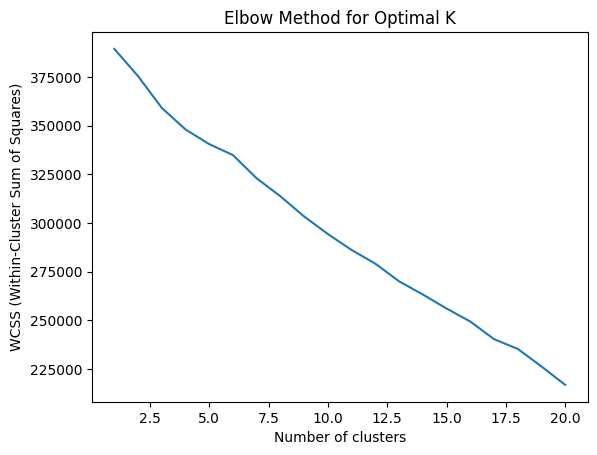

In [71]:
wcss = []
for i in range(1, 21):  # Try different values of n_clusters
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.plot(range(1, 21), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal K')
plt.show()

In [78]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=50, n_init=10)),  # Adjust the number of clusters as needed
#     ('pca', PCA(n_components=50)),
    ('classifier', LogisticRegression(max_iter = 2000))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=50, n_init=10)),
                ('classifier', LogisticRegression(max_iter=2000))])

In [79]:
predictions = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7333


In [82]:
report = classification_report(y_test, predictions,zero_division=0)
report

'              precision    recall  f1-score   support\n\n           0       0.75      1.00      0.86         3\n           1       1.00      0.25      0.40         4\n           2       0.00      0.00      0.00         1\n           3       0.57      1.00      0.73         4\n           4       1.00      1.00      1.00         3\n\n    accuracy                           0.73        15\n   macro avg       0.66      0.65      0.60        15\nweighted avg       0.77      0.73      0.67        15\n'